In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [3]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [4]:
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == np.argmax(Y_test[i])):
            acc += 1.0
    return acc / Y_test.shape[0]

In [5]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))

X_test = test_data['data']

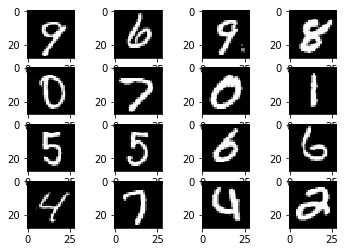

In [6]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [7]:
# Подготовка датасета, как требуется.
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

#mean = np.mean(X_train, axis=0)
#std = np.std(X_train, axis=0)
#X_train_stand = (X_train - mean) / (std+0.0001)

#X_train_stand = X_train / 255

X_train_stand = scale.fit_transform(X_train.astype(float))


#X_test_stand = (X_test - mean) / (std+0.0001)

#X_test_stand = X_test / 255

X_test_stand = scale.transform(X_test.astype(float))

In [8]:
# Определение слоев сети

class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2 / in_size)
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx
    
    
class ReLU:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz
    

class Softmax:
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x - np.max(x))
        return exps / exps.sum()
    
    def backward(self, dz, lr=0.001):
        sm  = self.forward(self.x)
        return np.matmul(sm * (np.eye(self.x.shape[0]) - sm).T, dz)
    
    
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum(y_true * np.log(y_hat))
    
    def backward(self, dz, lr=0.001):
        return dz * -1. * self.y_true / self.y_hat
    

class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

In [9]:
# Опеределение самой сети
# Я решил воспользоваться архитектурой, описаной в данной
# статье: https://www.kaggle.com/charel/learn-neural-networks-by-example-mnist-digits,
# но я добавил ещё два dropout'а.

class MnistNet:
    
    def __init__(self, rlambda=0.0):
        self.d = Dense(784, 200, rlambda)
        self.m = ReLU()
        self.dr = Dropout(p=0.08)
        self.d2 = Dense(200, 100, rlambda)
        self.m2 = ReLU()
        self.d3 = Dense(100, 60, rlambda)
        self.m3 = ReLU()
        self.dr3 = Dropout(p=0.01)
        self.d4 = Dense(60, 30, rlambda)
        self.m4 = ReLU()
        self.d5 = Dense(30, 10, rlambda)
        self.s = Softmax()
    
    def forward(self, x):
        net = self.d.forward(x)
        net = self.m.forward(net)
        net = self.dr.forward(net)
        net = self.d2.forward(net)
        net = self.m2.forward(net)
        net = self.d3.forward(net)
        net = self.m3.forward(net)
        net = self.dr3.forward(net)
        net = self.d4.forward(net)
        net = self.m4.forward(net)
        net = self.d5.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.d5.backward(dz, lr)
        dz = self.m4.backward(dz, lr)
        dz = self.d4.backward(dz, lr)
        dz = self.dr3.backward(dz, lr)
        dz = self.m3.backward(dz, lr)
        dz = self.d3.backward(dz, lr)
        dz = self.m2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.dr.backward(dz, lr)
        dz = self.m.backward(dz, lr)
        dz = self.d.backward(dz, lr)
        return dz
    
    def set_test(self):
        self.dr.set_train(False)
        self.dr3.set_train(False)
        
    def set_train(self):
        self.dr.set_train(True)
        self.dr3.set_train(True)

In [10]:
# Разобьём X_train на выборку, на которой будем тренироваться и выборку, на которой будем проводить валидацию.

from sklearn.model_selection import train_test_split

X_train_spl, X_test_spl, Y_train_spl, Y_test_spl = train_test_split(X_train_stand, Y_train_oh, random_state=42,
                                                                    test_size=0.2, stratify=Y_train_oh)

Отмечу, что я изначально посмотрел на гистограмму распределения классов, оказалось, что класов примерно поровну, поэтому я и не стал использовать $stratify$. Но ОК, исправил.

In [11]:
# Здесь процедура обучения
import tqdm

net = MnistNet(0.0001)
loss = CrossEntropy()
lr = 0.0005
L_train = []
L_test = []
L_accuracy_train = []
L_accuracy_test = []
#for iter in range(12):
for iter in range(1):
# for iter in tqdm.tqdm_notebook(range(1)):
    L_acc = 0.
    net.set_train()
    sh = list(range(X_train_spl.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    for i in range(X_train_spl.shape[0]):
    # for i in tqdm.tqdm_notebook(range(X_train_spl.shape[0])):
        x = X_train_spl[sh[i]]
        y = Y_train_spl[sh[i]]
        y_h = net.forward(x)        
        L = loss.forward(y, y_h) + net.d.get_reg_loss() + net.d2.get_reg_loss() + \
        net.d3.get_reg_loss() + net.d4.get_reg_loss() + net.d5.get_reg_loss()
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_accuracy_train.append(compute_acc(X_train_spl, Y_train_spl, net))
    L_acc /= Y_train_spl.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    net.set_test()
    for i in range(X_test_spl.shape[0]):
        x = X_test_spl[i]
        y = Y_test_spl[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) + net.d.get_reg_loss() + net.d2.get_reg_loss() + \
        net.d3.get_reg_loss() + net.d4.get_reg_loss() + net.d5.get_reg_loss()
        L_e_acc += L
    L_e_acc /= Y_test_spl.shape[0]
    L_test.append(L_e_acc)
    L_accuracy_test.append(compute_acc(X_test_spl, Y_test_spl, net))
    print("{} iter loss. Train : {} . Test : {}".format(iter, L_acc, L_e_acc))
    print("Accuracy. Train : {} . Test : {}".format(L_accuracy_train[-1], L_accuracy_test[-1]))

0 iter loss. Train : 0.5106879984197981 . Test : 0.2502479638008963
Accuracy. Train : 0.9392380952380952 . Test : 0.9426666666666667


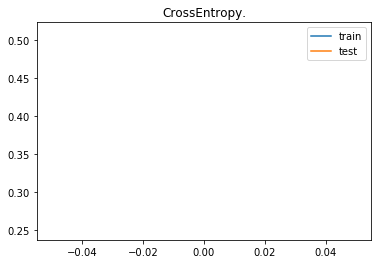

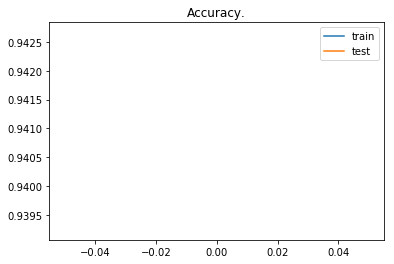

In [12]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
plt.title("CrossEntropy.")
plt.plot(L_train, label="train")
plt.plot(L_test, label="test")
plt.legend()
plt.show()

plt.title("Accuracy.")
plt.plot(L_accuracy_train, label="train")
plt.plot(L_accuracy_test, label="test")
plt.legend()
plt.show()

Обучение я останавливал после просмотра графиков и полученных значений кросс-энтропии.

In [13]:
# формируем сабмишшен и заливаем его на kaggle
#make_submission(X_test_stand, net)